<a href="https://colab.research.google.com/github/ChoiSenn/Study/blob/main/AI/PyTorch/PyTorch_2_%EB%AC%BC%EC%B2%B4%EA%B0%90%EC%A7%80(SSD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#2. 물체 감지 (SSD)

<br><br>

## 2-1. 물체 감지란

<br>

물체 감지는 한 장의 사진에 포함된 여러 물체에 대해 영역과 이름을 확인하는 작업.

물체 감지 결과, 바운딩 박스(BBox)라고 하는 물체의 위치를 나타내는 테두리, 감지된 클래스를 보여주는 라벨명, 라벨명 뒤에 붙어있는 숫자인 신뢰도(높을수록 정확)가 표시.

<br>

물체 감지에서 입력은 화상.

출력은 :
- 화상의 어디에 물체가 존재하는지 나타내는 바운딩 박스의 위치와 크기 정보
- 각 바운딩 박스가 어떤 물체인지 나타내는 라벨 정보
- 검색 신뢰도 = confidence

<br>

VOC 데이터셋(파스칼 VOC 챌린지)는 물체 탐지 대회에서 사용된 데이터셋으로, 클래스는 20종류, 훈련 데이터는 5,717장, 검증 데이터는 5,823장인 데이터셋.

<br>

SSD에서는 화상에서 물체의 바운딩 박스를 도출할 때 바운딩 박스의 정보를 출력하는 것이 아니라, 일반적인 사각형인 디폴트 박스를 준비해두고 어떻게 변형시키면 바운딩 박스가 되는지에 대한 정보를 출력.

디폴트 박스를 변형시키는 정보를 오프셋 정보라고 함.

SSD를 활용한 물체 감지 흐름 단계
- 1. 300 x 300으로 화상 리사이즈
- 2. 디폴트 박스 8,732개 준비
- 3. SSD 네트워크에 화상 입력
- 4. 신뢰도 높은 디폴트 박스 추출
- 5. 오프셋 정보로 수정 및 중복 제거
- 6. 일정 신뢰도 이상을 최종 출력으로 선정

<br><br>

## 2-2. 데이터셋 구현

<br>

사용할 폴더를 만들고 파일 다운로드.

In [3]:
# 패키지 import
import os.path as osp
import random
# 파일이나 텍스트에서 XML을 읽고, 가공하고 저장하기 위한 라이브러리
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

%matplotlib inline

# 난수 시드 설정
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [4]:
import os
import urllib.request
import zipfile
import tarfile

# "data" 폴더가 존재하지 않는 경우 작성한다
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

# "weights" 폴더가 존재하지 않는 경우 작성한다
weights_dir = "./weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

# VOC2012의 데이터 세트를 여기서 다운로드합니다
# 시간이 걸립니다(약 15분)
url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
target_path = os.path.join(data_dir, "VOCtrainval_11-May-2012.tar") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)
    
    tar = tarfile.TarFile(target_path)  # tar 파일 읽기
    tar.extractall(data_dir)  # tar를 압축 해제
    tar.close()  # tar 파일 닫기

# 학습된 SSD용의 VGG 파라미터를 "weights" 폴더에 다운로드
# MIT License
# Copyright (c) 2017 Max deGroot, Ellis Brown
# https://github.com/amdegroot/ssd.pytorch
    
url = "https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth"
target_path = os.path.join(weights_dir, "vgg16_reducedfc.pth") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

# 학습된 SSD300 모델을 "weights" 폴더에 다운로드
# MIT License
# Copyright (c) 2017 Max deGroot, Ellis Brown
# https://github.com/amdegroot/ssd.pytorch

url = "https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth"
target_path = os.path.join(weights_dir, "ssd300_mAP_77.43_v2.pth") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

In [22]:
!pip uninstall torch
!pip install torch==1.1.0 torchvision==0.3.0

Found existing installation: torch 1.0.0
Uninstalling torch-1.0.0:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/lib/python3.7/dist-packages/caffe2/*
    /usr/local/lib/python3.7/dist-packages/torch-1.0.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/torch/*
Proceed (y/n)? y
  Successfully uninstalled torch-1.0.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 676.9 MB 3.9 kB/s 
     |████████████████████████████████| 2.6 MB 48.4 MB/s 
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.2.1
    Uninstalling torchvision-0.2.1:
      Successfully uninstalled torchvision-0.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.1 requires torch==1.12.1, but

1.12.1+cu113
0.2.1


In [2]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

1.1.0
0.3.0


물체 감지용 데이터셋 구현에서 1장의 화상 분류 데이터셋과 다른 점은 어노테이션 데이터.

화상 분류에서는 파일 및 폴더 이름에 클래스명이 포함되었고, 해답 데이터(어노테이션 데이터)는 없음.

물체 감지에서 물체 위치와 라벨의 해답이 되는 어노테이션은 바운딩 박스의 정보이며, 어노테이션 데이터로 제공됨. 즉, 물체 감지는 화상 데이터와 함께 어노테이션 데이터를 데이터셋에서 처리해야 함.

화상 전처리나 훈련 시의 데이터 확장에서 입력 화상의 크기가 변경되면 어노테이션 데이터의 바운딩 박스 정보도 함께 변경되야 함.

<br>

먼저 화상 데이터와 어노테이션 데이터의 파일 경로를 리스트형 변수로 만듦. 훈련 및 검증용으로 총 네 개의 리스트를 작성.

train.txt와 val.txt를 읽어들여 훈련 및 검증 데이터 각 파일의 ID를 받은 후, 화상과 어노테이션 파일의 경로 리스트를 만듦.

In [ ]:
# 학습 및 검증용 화상 데이터, 어노테이션 데이터의 파일 경로 리스트를 작성
def make_datapath_list(rootpath):
    """
    데이터의 경로를 저장한 리스트를 작성한다.

    Parameters
    ----------
    rootpath : str
        데이터 폴더의 경로

    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        데이터의 경로를 저장한 리스트
    """

    # 화상 파일과 어노테이션 파일의 경로 템플릿을 작성
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'Annotations', '%s.xml')

    # 훈련 및 검증 각각의 파일 ID(파일 이름)를 취득
    train_id_names = osp.join(rootpath + 'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Main/val.txt')

    # 훈련 데이터의 화상 파일과 어노테이션 파일의 경로 리스트를 작성
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # 공백과 줄바꿈 제거
        img_path = (imgpath_template % file_id)  # 화상의 경로
        anno_path = (annopath_template % file_id)  # 어노테이션의 경로
        train_img_list.append(img_path)  # 리스트에 추가
        train_anno_list.append(anno_path)  # 리스트에 추가

    # 검증 데이터의 화상 파일과 어노테이션 파일의 경로 리스트 작성
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 공백과 줄바꿈 제거
        img_path = (imgpath_template % file_id)  # 화상의 경로
        anno_path = (annopath_template % file_id)  # 어노테이션의 경로
        val_img_list.append(img_path)  # 리스트에 추가
        val_anno_list.append(anno_path)  # 리스트에 추가

    return train_img_list, train_anno_list, val_img_list, val_anno_list

파일 경로 리스트를 작성하고 제대로 동작하는지 확인.

In [ ]:
# 파일 경로 리스트 작성
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath)

# 동작 확인
print(train_img_list[0])

./data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg


어노테이션 데이터는 xml 형식이므로, xml 데이터를 파이썬 리스트형 변수로 변환하는 클래스를 작성.

\_\_call__을 메소드(대상 화상의 폭과 높이를 인수로 사용하여 바운딩 박스의 좌표를 구격화)로 구현하고 클래스명과 동일한 이름으로 변환 함수를 실행. 규격화는 BBox의 정보를 화상의 폭 또는 높이로 나눔. 어노테이션 데이터에는 물체의 이름이 물체의 클래스명의 문자열로 저장되었고 숫자로 변경해야 함.

Anno 클래스의 인스턴스를 실행할 때 생성자의 인수에 VOC 데이터셋의 클래스명 스무 개를 배치한 리스트 classes를 할당하고 클래스명을 인덱스 label_idx = self.classes.index(name)으로 바꿈.

In [ ]:
# "XML 형식의 어노테이션"을 리스트 형식으로 변환하는 클래스
class Anno_xml2list(object):
    """
    한 장의 이미지에 대한 "XML 형식의 어노테이션 데이터"를 화상 크기로 규격화해 리스트 형식으로 변환한다.

    Attributes
    ----------
    classes : 리스트
        VOC의 클래스명을 저장한 리스트
    """

    def __init__(self, classes):

        self.classes = classes

    def __call__(self, xml_path, width, height):
        """
        한 장의 이미지에 대한 "XML 형식의 어노테이션 데이터"를 화상 크기로 규격화해 리스트 형식으로 변환한다.

        Parameters
        ----------
        xml_path : str
            xml 파일의 경로.
        width : int
            대상 화상의 폭.
        height : int
            대상 화상의 높이.

        Returns
        -------
        ret : [[xmin, ymin, xmax, ymax, label_ind], ... ]
            물체의 어노테이션 데이터를 저장한 리스트. 이미지에 존재하는 물체수만큼의 요소를 가진다.
        """

        # 화상 내 모든 물체의 어노테이션을 이 리스트에 저장합니다
        ret = []

        # xml 파일을 로드
        xml = ET.parse(xml_path).getroot()

        # 화상 내에 있는 물체(object)의 수만큼 반복
        for obj in xml.iter('object'):

            # 어노테이션에서 감지가 difficult로 설정된 것은 제외
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue

            # 한 물체의 어노테이션을 저장하는 리스트
            bndbox = []

            name = obj.find('name').text.lower().strip()  # 물체 이름
            bbox = obj.find('bndbox')  # 바운딩 박스 정보

            # 어노테이션의 xmin, ymin, xmax, ymax를 취득하고, 0~1으로 규격화
            pts = ['xmin', 'ymin', 'xmax', 'ymax']

            for pt in (pts):
                # VOC는 원점이 (1,1)이므로 1을 빼서 (0, 0)으로 한다
                cur_pixel = int(bbox.find(pt).text) - 1

                # 폭, 높이로 규격화
                if pt == 'xmin' or pt == 'xmax':  # x 방향의 경우 폭으로 나눈다
                    cur_pixel /= width
                else:  # y 방향의 경우 높이로 나눈다
                    cur_pixel /= height

                bndbox.append(cur_pixel)

            # 어노테이션의 클래스명 index를 취득하여 추가
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)

            # res에 [xmin, ymin, xmax, ymax, label_ind]을 더한다
            ret += [bndbox]

        return np.array(ret)  # [[xmin, ymin, xmax, ymax, label_ind], ... ]

Anno 클래스의 동작을 확인.

출력되는 리스트형 변수의 어노테이션 정보는 요소 수가 화상에 존재하는 물체의 수이며 각 요소는 다섯 가지 값으로 이루어진 리스트임. 다섯 가지 값은 BBox의 위치 정보와 클래스의 인덱스.

실행 결과를 보면 클래스 인덱스 18(train)과 14(person)의 물체가 화상에 존재한다는 것을 알 수 있음.

In [ ]:
# 동작 확인
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

transform_anno = Anno_xml2list(voc_classes)

# 화상 로드용으로 OpenCV를 사용
ind = 1
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path)  # [높이][폭][색BGR]
height, width, channels = img.shape  # 화상 크기 취득

# 어노테이션을 리스트로 표시
transform_anno(val_anno_list[ind], width, height)

array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

이제 화상과 BBox에 전처리를 실시하는 DataTransform 클래스를 만듦. 학습 시와 추론 시에 다르게 작동하도록 설정.

학습 시에 DataTransform은 데이터 확장을 함. 화상과 BBox를 동시에 변형해야 하므로 해당 클래스를 직접 만듦.

훈련 시의 데이터 확장에서는 색조를 변환하고 화상 크기를 변경하여 임의로 자르는 작업을 수행. 또한, 화상의 크기를 리사이즈하고 색상 정보의 평균값을 뺌. 추론 시에는 화상의 크기를 변환하고 색상의 평균값을 빼기만 하면 됨.

화상 데이터를 불러올 때 OpenCV를 사용. 색상 채널의 RGB가 아닌 BGR인 점에 주의.

DataTransform 클래스를 작성.

In [ ]:
# "utils" 폴더에 있는 data_augumentation.py에서 import.
# 입력 영상의 전처리 클래스
from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans


class DataTransform():
    """
    화상과 어노테이션의 전처리 클래스. 훈련과 추론에서 다르게 작동한다.
    화상의 크기를 300x300으로 한다.
    학습시 데이터 확장을 수행한다.

    Attributes
    ----------
    input_size : int
        리사이즈 대상 화상의 크기.
    color_mean : (B, G, R)
        각 색상 채널의 평균값.
    """

    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),  # int를 float32로 변환
                ToAbsoluteCoords(),  # 어노테이션 데이터의 규격화를 반환
                PhotometricDistort(),  # 화상의 색조 등을 임의로 변화시킴
                Expand(color_mean),  # 화상의 캔버스를 확대
                RandomSampleCrop(),  # 화상 내의 특정 부분을 무작위로 추출
                RandomMirror(),  # 화상을 반전시킨다
                ToPercentCoords(),  # 어노테이션 데이터를 0-1로 규격화
                Resize(input_size),  # 화상 크기를 input_size × input_size로 변형
                SubtractMeans(color_mean)  # BGR 색상의 평균값을 뺀다
            ]),
            'val': Compose([
                ConvertFromInts(),  # int를 float로 변환
                Resize(input_size),  # 화상 크기를 input_size × input_size로 변형
                SubtractMeans(color_mean)  # BGR 색상의 평균값을 뺀다
            ])
        }

    def __call__(self, img, phase, boxes, labels):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            전처리 모드를 지정.
        """
        return self.data_transform[phase](img, boxes, labels)

DataTransform 클래스의 동작을 확인. 원본 화상, 전처리로 변화된 훈련 시 화상, 전처리로 변화된 검증 시 화상이 출력.

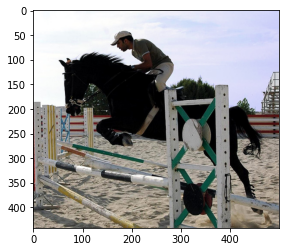

/content/utils/data_augumentation.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)


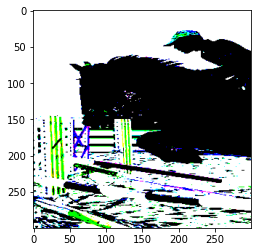

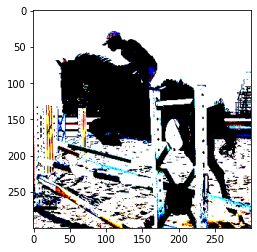

In [ ]:
# 동작 확인

# 1. 화상 읽기
image_file_path = train_img_list[0]
img = cv2.imread(image_file_path)  # [높이][폭][색BGR]
height, width, channels = img.shape  # 화상의 크기 취득

# 2. 어노테이션을 리스트로
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)

# 3. 원래 화상을 표시
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 전처리 클래스 작성
color_mean = (104, 117, 123)  # (BGR) 색상의 평균값
input_size = 300  # 화상의 input 사이즈를 300×300으로
transform = DataTransform(input_size, color_mean)

# 5. train화상의 표시
phase = "train"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


# 6. val화상의 표시
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

코드에서 anno_list[:, :4]는 어노테이션 데이터 BBox의 좌표 정보를 나타내며, anno_list[:, 4]는 물체의 클래스명에 대응하는 인덱스 정보. 

<br>

마지막으로 파이토치의 Dataset 클래스를 상속받아 VOCDataset 클래스를 만듦.

\_\_getitem()__ 함수를 정의하고 전처리한 화상의 텐서 형식 데이터와 어노테이션을 취득.

OpenCV에서 가져온 [높이][폭][색BGR] 형식의 화상 데이터를 [색RGB][높이][폭]이 되도록 요소 및 색상 채널의 순서 변경.

In [ ]:
# VOC2012의 Dataset을 작성
class VOCDataset(data.Dataset):
    """
    VOC2012의 Dataset을 만드는 클래스. PyTorch의 Dataset 클래스를 상속받는다.

    Attributes
    ----------
    img_list : 리스트
        화상의 경로를 저장한 리스트
    anno_list : 리스트
        어노테이션의 경로를 저장한 리스트
    phase : 'train' or 'test'
        학습 또는 훈련을 설정한다.
    transform : object
        전처리 클래스의 인스턴스
    transform_anno : object
        xml 어노테이션을 리스트로 변환하는 인스턴스
    """

    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase  # train 또는 val을 지정
        self.transform = transform  # 화상의 변형
        self.transform_anno = transform_anno  # 어노테이션 데이터를 xml에서 리스트로 변경

    def __len__(self):
        '''화상의 매수를 반환'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        전처리한 화상의 텐서 형식 데이터와 어노테이션을 취득
        '''
        im, gt, h, w = self.pull_item(index)
        return im, gt

    def pull_item(self, index):
        '''전처리한 화상의 텐서 형식 데이터, 어노테이션, 화상의 높이, 폭을 취득한다'''

        # 1. 화상 읽기
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [높이][폭][색BGR]
        height, width, channels = img.shape  # 화상의 크기 취득

        # 2. xml 형식의 어노테이션 정보를 리스트에 저장
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)

        # 3. 전처리 실시
        img, boxes, labels = self.transform(
            img, self.phase, anno_list[:, :4], anno_list[:, 4])

        # 색상 채널의 순서가 BGR이므로 RGB로 순서를 변경
        # 또한 (높이, 폭, 색상 채널)의 순서를 (색상 채널, 높이, 폭)으로 변경
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)

        # BBox와 라벨을 세트로 한 np.array를 작성, 변수 이름 "gt"는 ground truth의 약칭
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

        return img, gt, height, width

Dataset의 동작을 확인.

검증용 Dataset인 val_dataset을 \_\_getitem__한 출력은 다음과 같음.

In [ ]:
# 동작 확인
color_mean = (104, 117, 123)  # (BGR) 색의 평균값
input_size = 300  # 화상의 input 사이즈를 300×300으로 함

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))


# 데이터 출력의 예
val_dataset.__getitem__(1)

(tensor([[[   0.9417,    6.1650,   11.1283,  ...,  -22.9083,  -13.2200,
             -9.4033],
          [   6.4367,    9.6600,   13.8283,  ...,  -21.4433,  -18.6500,
            -18.2033],
          [  10.8833,   13.5500,   16.7000,  ...,  -20.9917,  -24.5250,
            -25.1917],
          ...,
          [ -23.9500,  -14.9000,   -1.7583,  ..., -108.6083, -111.0000,
           -117.8083],
          [ -28.2817,  -20.1750,   -5.5633,  ..., -104.9933, -111.8350,
           -119.0000],
          [ -20.4767,  -21.0000,  -12.6333,  ..., -107.1683, -115.7800,
           -117.1100]],
 
         [[  25.9417,   30.1650,   35.1283,  ...,  -18.0767,  -14.7250,
            -11.8533],
          [  31.4367,   33.6600,   37.8283,  ...,  -13.5017,  -10.8250,
            -10.3783],
          [  35.7917,   37.5500,   40.7000,  ...,  -11.8417,  -13.0750,
            -14.0167],
          ...,
          [  -1.9500,    7.1000,   20.2417,  ..., -101.9083, -102.0000,
           -109.7167],
          [  -6.2

<br><br>

## 2-3. 데이터 로더 구현

<br>

SSD의 학습 및 추론 시 데이터를 미니 배치로 꺼내기 위한 DataLoader 클래스를 구현.

<br>

물체 감지의 경우, 화상 분류와는 다르게 화상 데이터마다 Dataset에서 꺼낼 어노테이션 데이터 정보, gt 변수의 크기(화상 내의 물체 수)가 다름. gt는 리스트형 변수이고 요소는 화상 속 물체 수.

Dataset에서 꺼내는 변수의 크기가 데이터마다 다르다면 DataLoader 클래스에서 기본적으로 사용하는 데이터 추출 함수인 collate_fn을 별도로 만들어야 함.

In [ ]:
def od_collate_fn(batch):
    """
    Dataset에서 꺼내는 어노테이션 데이터의 크기는 화상마다 다릅니다.
    화상 내의 물체 수가 2개이면 (2, 5) 이지만, 3개이면 (3, 5) 등으로 변화합니다.
    이러한 변화에 대응한 DataLoader을 작성하기 위해 커스터마이즈한 collate_fn을 만듭니다.
    collate_fn은 PyTorch 리스트로 mini-batch를 작성하는 함수입니다.
    미니 배치 분량의 화상이 나열된 리스트 변수 batch에 미니 배치 번호를 지정하는 차원을 선두에 하나 추가하여 리스트의 형태를 바꿉니다.
    """

    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])  # sample[0]은 화상img입니다
        targets.append(torch.FloatTensor(sample[1]))  # sample[1]은 어노테이션 gt입니다

    # imgs는 미니 배치 크기의 리스트입니다
    # 리스트의 요소는 torch.Size([3, 300, 300]) 입니다
    # 이 리스트를 torch.Size([batch_num, 3, 300, 300])의 텐서로 변환합니다
    imgs = torch.stack(imgs, dim=0)

    # targets은 어노테이션의 정답인 gt의 리스트입니다
    # 리스트의 크기는 미니 배치의 크기가 됩니다
    # targets 리스트의 요소는 [n, 5] 로 되어 있습니다
    # n은 화상마다 다르며, 화상 속 물체의 수입니다
    # 5는 [xmin, ymin, xmax, ymax, class_index] 입니다

    return imgs, targets

ob_collage_fn 함수로 DataLoader를 만듦. 작성 후 동작을 확인하여 미니 배치의 화상과 어노테이션 데이터를 얻을 수 있는지 확인.

검증용 DataLoader의 첫 번째 데이터를 획득해봄.

In [ ]:
# 데이터 로더 작성

batch_size = 4

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# 사전형 변수에 정리
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict["val"])  # 반복자로 변환
images, targets = next(batch_iterator)  # 첫 번째 요소를 추출
print(images.size())  # torch.Size([4, 3, 300, 300])
print(len(targets))
print(targets[1].size())  # 미니 배치 크기의 리스트, 각 요소는 [n, 5], n은 물체 수

torch.Size([4, 3, 300, 300])
4
torch.Size([2, 5])


DataLoader에서 꺼낸 화상 images는 텐서 크기(미니 배치 수, 색상 채널, 높이, 폭)로 되어있음. 어노테이션 정보 targets는 미니 배치 크기의 리스트이며 리스트의 각 요소는 (화상 속 물체 수, 5) 크기의 텐서.

물체 감지용 DataLoader를 완성하고 데이터 수를 확인.

In [ ]:
print(train_dataset.__len__())
print(val_dataset.__len__())

5717
5823


훈련 데이터와 검증 데이터 개수 확인 가능.

<br><br>

## 2-4. 네트워크 모델 구현

<br>

SSD 네트워크의 입력은 전처리된 화상 데이터이며 크기는 300 x 300 픽셀.

SSD 네트워크 모델의 출력은 8,732개의 DBox에 대한 오프셋 정보와 각 클래스에 대한 21종류의 신뢰도.

SSD의 주요 서브 네트워크는 vgg, extra, loc, conf 네 가지.

<br>

먼저, 입력 화상은 vgg 모둘에 입력됨. VGG-16 모델이 vgg 모듈의 기반. 합성곱 층의 커널 크기와 사용하는 유닛이 동일. 다만, 각 유닛의 특징량 맵 크기는 VGG-16과 다름.

vgg 모듈에서 10회의 합성곱을 받은 데이터(conv4_3)는 별도로 추출하여 L2Norm 층에서 크기를 정규화한 후, 변수 source1로 함. 변수 source1은 채널 수 512, 특징량 맵 크기는 38 x 38.

다시 5회 합성곱을 받은 vgg 모듈의 출력 데이터를 변수 source2로 함. 변수 source2는 특징량 맵 크기가 19 x 19.

이어서 vgg 모듈의 출력을 extra 모듈에 입력. 이는 최대 풀링을 사용하지 않고 합성곱 처리를 총 8회 실시. 2회 합성곱마다 출력치를 source3~6으로 함. 총 네 개의 소스 출력. 각 소스의 특징량 맵 크기는 각각 10x10, 5x5, 3x3, 1x1.

소스마다 특징량 맵 크기가 다르다는 점이 중요. 특징량 맵 크기가 서로 다른 source1~6을 작성하여 화상 속 다양한 크기의 물체를 상정한 특징량을 얻을 수 있음.

다만 source1~6은 합성곱 처리를 실시한 횟수가 다름. 특징량 맵 크기가 큰, 즉 작은 물체에 주목하는 source1 쪽이 source6보다 합성곱 처리 횟수가 적음. SSD는 source1이나 2와 같은 작은 영역의 특징량을 추출하는 물체 감지가 미숙하여 화상 속 작은 물체를 감지하는 정밀도가 큰 물체의 감지보다 낮음.

<br>

vgg 모듈을 구현하는 make_vgg 함수를 정의. 

합성곱 층, ReLU, 최대 풀링을 총 34유닛 준비. 각 합성곱 층의 채널 수와 최대 풀링 층의 정보를 구성 변수로 하여 cfg = [64, 64, 'M', ...]로 작성하고 그 요소의 값에 따라 유닐을 만듦.

리스트형 변수 cfg의 요소 'M'은 최대 풀링 층을, 'MC'는 ceil 모드의 최대 풀링 층. 

ReLU 인수 inplace는 ReLU에 대한 입력을 메모리 상에 유지할 것인지, 입력을 재작성하여 출력으로 바꾼 후 메모리 상에 유지하지 않을 것인지 나타냄. True로 하면 입력을 재작성. 메모리 상에 입력을 유지하지 않도록 설정하고 메모리를 절약할 수 있음.

In [ ]:
# 패키지 import
from math import sqrt
from itertools import product

import pandas as pd
import torch
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

In [ ]:
# 34층에 걸쳐, vgg모듈을 작성
def make_vgg():
    layers = []
    in_channels = 3  # 색 채널 수 

    # vgg 모듈에서 사용하는 합성곱 층이나 맥스 풀링의 채널 수
    cfg = [64, 64, 'M', 128, 128, 'M', 256, 256,
           256, 'MC', 512, 512, 512, 'M', 512, 512, 512]

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'MC':
            # ceil은 출력 크기를 계산 결과(float)에 대해, 소수점을 올려 정수로 하는 모드
            # 디폴트는 출력 크기를 계산 결과(float)에 대해, 소수점을 버려 정수로 하는 floor 모드
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6,
               nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return nn.ModuleList(layers)


# 동작 확인
vgg_test = make_vgg()
print(vgg_test)

ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(256, 512, kernel_siz

vgg 모듈을 구현하는 make_extras 함수를 구현.

합성곱 층을 총 8유닛 나열. 이번에는 활성화 함수의 ReLU를 SSD 모델의 순전파 함수 내에서 준비하고 extra 모듈에서는 준비하지 않음.

In [ ]:
# 8층에 걸친 extras모듈 작성
def make_extras():
    layers = []
    in_channels = 1024  # vgg모듈에서 출력된, extra에 입력되는 화상 채널 수

    # extra모듈의 합성곱층의 채널수를 설정하는 구성(configuration)
    cfg = [256, 512, 128, 256, 128, 256, 128, 256]

    layers += [nn.Conv2d(in_channels, cfg[0], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[0], cfg[1], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[1], cfg[2], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[2], cfg[3], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[3], cfg[4], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[4], cfg[5], kernel_size=(3))]
    layers += [nn.Conv2d(cfg[5], cfg[6], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[6], cfg[7], kernel_size=(3))]
    
    # 활성화 함수의 ReLU는 이번에는 SSD모듈의 순전파 속에서 준비하는 것으로 하고,
    # extra모듈에서는 준비하지 않음

    return nn.ModuleList(layers)

# 동작 확인
extras_test = make_extras()
print(extras_test)

ModuleList(
  (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
)


loc과 conf를 구현하는 make_loc_conf 함수를 구편.

각각 여섯 개의 합성곱 층을 준비. loc과 conf 모듈은 각각 여섯 개의 합성곱 층을 준비하여 하나의 모듈로 함. 하지만 여섯 개의 합성곱 층을 앞에서 뒤로 순전파하지는 않음.

각 소스로 사용하는 DBox 수를 bbox_aspect_num 인수로 설정하여 구현.

In [ ]:
# 디폴트 박스의 오프셋을 출력하는 loc_layers,
# 디폴트 박스에 대한 각 클래스의 신뢰도 confidence를 출력하는 conf_layers를 작성
def make_loc_conf(num_classes=21, bbox_aspect_num=[4, 6, 6, 6, 4, 4]):

    loc_layers = []
    conf_layers = []

    # VGG의 22층, conv4_3(source1)에 대한 합성곱층
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[0]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[0]
                              * num_classes, kernel_size=3, padding=1)]

    # VGG의 최종층(source2)에 대한 합성곱층
    loc_layers += [nn.Conv2d(1024, bbox_aspect_num[1]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(1024, bbox_aspect_num[1]
                              * num_classes, kernel_size=3, padding=1)]

    # extra(source3)에 대한 합성곱층
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[2]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[2]
                              * num_classes, kernel_size=3, padding=1)]

    # extra(source4)에 대한 합성곱층
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[3]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[3]
                              * num_classes, kernel_size=3, padding=1)]

    # extra(source5)에 대한 합성곱층
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[4]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[4]
                              * num_classes, kernel_size=3, padding=1)]

    # extra(source6)에 대한 합성곱층
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[5]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[5]
                              * num_classes, kernel_size=3, padding=1)]

    return nn.ModuleList(loc_layers), nn.ModuleList(conf_layers)


# 동작 확인
loc_test, conf_test = make_loc_conf()
print(loc_test)
print(conf_test)

ModuleList(
  (0): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
ModuleList(
  (0): Conv2d(512, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


출력에 적용하는 L2Norm 층을 구현.

L2Norm 층은 특징량 맵의 통계적 특성이 채널마다 다른 점을 정규화함. 이번에는 L2Norm 층에 대한 입력은 (512채널 x 38 x 38) 텐서를 활용. 38 x 38 = 1,444개의 셀에 대해 512채널에 걸쳐 정규화. 1,444개의 셀마다 각 채널의 특징량 제곱을 계산하고 이를 512개 더하여 루트를 계산. 채널의 각 셀 값을 제곱합의 루트로 나누어 정규화. 채널별로 특징량의 크기가 다른 것을 채널 방향으로 정규화하여 해결.

L2Norm 층에서는 정규화한 512채널 x 38 x 38 텐서에 각 채널 계수를 곱함. 512개의 계수는 학습할 파라미터.

다음과 같이 파이토치 네트워크 층 클래스인 nn.Module을 상속하여 구현.

In [ ]:
# convC4_3로부터의 출력을 scale=20의 L2Norm으로 정규화하는 층
class L2Norm(nn.Module):
    def __init__(self, input_channels=512, scale=20):
        super(L2Norm, self).__init__()  # 부모 클래스의 생성자 실행
        self.weight = nn.Parameter(torch.Tensor(input_channels))
        self.scale = scale  # 계수 weight의 초기값으로 설정할 값
        self.reset_parameters()  # 파라미터의 초기화
        self.eps = 1e-10

    def reset_parameters(self):
        '''결합 파라미터의 scale크기 값으로 초기화 실행'''
        init.constant_(self.weight, self.scale)  # weight의 값이 모두 scale(=20)이 된다

    def forward(self, x):
        '''38×38의 특징량에 대해 512 채널에 걸쳐 제곱합의 루트를 구했다
        38×38개의 값을 사용하여 각 특징량을 정규화한 후 계수를 곱하여 계산하는 층'''

        # 각 채널에서의 38×38개의 특징량의 채널 방향의 제곱합을 계산하고,
        # 또한 루트를 구해 나누어 정규화한다
        # norm의 텐서 사이즈는 torch.Size([batch_num, 1, 38, 38])입니다
        norm = x.pow(2).sum(dim=1, keepdim=True).sqrt()+self.eps
        x = torch.div(x, norm)

        # 계수를 곱한다. 계수는 채널마다 하나로, 512개의 계수를 갖는다
        # self.weight의 텐서 사이즈는 torch.Size([512])이므로
        # torch.Size([batch_num, 512, 38, 38])까지 변형합니다
        weights = self.weight.unsqueeze(
            0).unsqueeze(2).unsqueeze(3).expand_as(x)
        out = weights * x

        return out

마지막으로 8,732개의 디폴트 박스를 준비하는 클래스를 만듦. source1~6까지 크기가 서로 다른 특징량 맵에 대해 각각 4 또는 6 종류의 DBox를 만듦.

소스 코드 중 for i, j in product(...)는 조합을 꺼내는 명령어. 이런 조합의 취득을 활용하여 DBox의 중심 좌표를 작성.

In [ ]:
# 디폴트 박스를 출력하는 클래스
class DBox(object):
    def __init__(self, cfg):
        super(DBox, self).__init__()

        # 초기설정
        self.image_size = cfg['input_size']  # 화상 크기 300
        # [38, 19, …] 각 source의 특징량 맵의 크기
        self.feature_maps = cfg['feature_maps']
        self.num_priors = len(cfg["feature_maps"])  # source의 개수 6
        self.steps = cfg['steps']  # [8, 16, …] DBox의 픽셀 크기
        
        self.min_sizes = cfg['min_sizes']
        # [30, 60, …] 작은 정사각형의 DBox 픽셀 크기(정확히는 면적)
        
        self.max_sizes = cfg['max_sizes']
        # [60, 111, …] 큰 정사각형의 DBox 픽셀 크기(정확히는 면적)
        
        self.aspect_ratios = cfg['aspect_ratios']  # 정사각형의 DBox의 화면비(종횡비)

    def make_dbox_list(self):
        '''DBox를 작성한다'''
        mean = []
        # 'feature_maps': [38, 19, 10, 5, 3, 1]
        for k, f in enumerate(self.feature_maps):
            for i, j in product(range(f), repeat=2):  # f까지의 수로 두 쌍의 조합을 작성한다 f_P_2개
                # 특징량의 화상 크기
                # 300 / 'steps': [8, 16, 32, 64, 100, 300],
                f_k = self.image_size / self.steps[k]

                # DBox의 중심 좌표 x,y. 0~1로 정규화되어 있음
                cx = (j + 0.5) / f_k
                cy = (i + 0.5) / f_k

                # 화면비 1의 작은 DBox [cx,cy, width, height]
                # 'min_sizes': [30, 60, 111, 162, 213, 264]
                s_k = self.min_sizes[k]/self.image_size
                mean += [cx, cy, s_k, s_k]

                # 화면비 1의 큰 DBox [cx,cy, width, height]
                # 'max_sizes': [60, 111, 162, 213, 264, 315],
                s_k_prime = sqrt(s_k * (self.max_sizes[k]/self.image_size))
                mean += [cx, cy, s_k_prime, s_k_prime]

                # 그 외 화면비의 defBox [cx,cy, width, height]
                for ar in self.aspect_ratios[k]:
                    mean += [cx, cy, s_k*sqrt(ar), s_k/sqrt(ar)]
                    mean += [cx, cy, s_k/sqrt(ar), s_k*sqrt(ar)]

        # DBox를 텐서로 변환 torch.Size([8732, 4])
        output = torch.Tensor(mean).view(-1, 4)

        # DBox가 화상 밖으로 돌출되는 것을 막기 위해, 크기를 최소 0, 최대 1로 한다
        output.clamp_(max=1, min=0)

        return output

동작을 확인하면 DBox의 좌표 정보 표가 출력.

In [ ]:
# 동작 확인

# SSD300 설정
ssd_cfg = {
    'num_classes': 21,  # 배경 클래스를 포함한 총 클래스 수
    'input_size': 300,  # 화상의 입력 크기
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 출력할 Box 화면비의 종류
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 각 source의 화상 크기
    'steps': [8, 16, 32, 64, 100, 300],  # DBOX의 크기를 정한다
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOX의 크기를 정한다
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOX의 크기를 정한다
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# DBox 작성
dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()

# DBox 출력을 확인한다
pd.DataFrame(dbox_list.numpy())

,0,1,2,3
0,0.013333,0.013333,0.100000,0.100000
1,0.013333,0.013333,0.141421,0.141421
2,0.013333,0.013333,0.141421,0.070711
3,0.013333,0.013333,0.070711,0.141421
4,0.040000,0.013333,0.100000,0.100000
...,...,...,...,...
8727,0.833333,0.833333,0.502046,1.000000
8728,0.500000,0.500000,0.880000,0.880000
8729,0.500000,0.500000,0.961249,0.961249
8730,0.500000,0.500000,1.000000,0.622254


작성한 모듈들을 이용하여 SSD 클래스를 구현. 파이토치 네트워크 층 클래스인 nn.Module을 상속.

SSD 클래스는 훈련할 때와 추론할 때 다르게 동작 추론할 때는 Detect 클래스를 사용.

In [ ]:
# SSD 클래스를 작성한다
class SSD(nn.Module):

    def __init__(self, phase, cfg):
        super(SSD, self).__init__()

        self.phase = phase  # train or inference를 지정
        self.num_classes = cfg["num_classes"]  # 클래스 수 21

        # SSD 네트워크를 작성
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(
            cfg["num_classes"], cfg["bbox_aspect_num"])

        # DBox 작성
        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()

        # 추론시는 "Detect" 클래스를 준비합니다
        if phase == 'inference':
            self.detect = Detect()


# 동작 확인
ssd_test = SSD(phase="train", cfg=ssd_cfg)
print(ssd_test)

SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

<br><br>

## 2-5. 순전파 함수 구현

<br>

SSD 모델의 순전파 함수를 정의. 화상 분류에서 사용된 신경망은 단순히 모델의 층(유닛)을 앞에서 뒤로 처리했으나, 물체 감지는 더 복잡하게 순전파 처리를 해야 함.

<br>

SSD 추론 시에는 순전파 끝에 Detect 클래스를 적용. Detect 클래스에서 사용하는 decode 함수와 nm_supression 함수를 구현.

In [ ]:
# 오프셋 정보를 이용하여 DBox를 BBox로 변환하는 함수
def decode(loc, dbox_list):
    """
    오프셋 정보를 이용하여 DBox를 BBox로 변환한다.

    Parameters
    ----------
    loc:  [8732,4]
        SSD 모델로 추론하는 오프셋 정보.
    dbox_list: [8732,4]
        DBox 정보

    Returns
    -------
    boxes : [xmin, ymin, xmax, ymax]
        BBox 정보
    """

    # DBox는 [cx, cy, width, height]로 저장되어 있음
    # loc도 [Δcx, Δcy, Δwidth, Δheight]로 저장되어 있음

    # 오프셋 정보로 BBox를 구한다
    boxes = torch.cat((
        dbox_list[:, :2] + loc[:, :2] * 0.1 * dbox_list[:, 2:],
        dbox_list[:, 2:] * torch.exp(loc[:, 2:] * 0.2)), dim=1)
    # boxes의 크기는 torch.Size([8732, 4])가 됩니다

    # BBox의 좌표정보를 [cx, cy, width, height]에서 [xmin, ymin, xmax, ymax]으로 변경
    boxes[:, :2] -= boxes[:, 2:] / 2  # 좌표 (xmin,ymin)로 변환
    boxes[:, 2:] += boxes[:, :2]  # 좌표 (xmax,ymax)로 변환

    return boxes

Detect 클래스에서 사용하는 Non-Maximum Suppression을 실시하는 nm_supression 함수를 구현.

Non-Maximum Suppression : 미리 8,732개의 DBox를 준비하여 물체를 감지하므로 BBox를 계산하면 화상 속 동일한 물체에 다른 BBox가 조금 다르게 복수 피팅 될 때가 있음. 겹치는 BBox를 삭제하고 하나의 물체에 하나의 BBox만 남기는 처리를 의미.

Non-Maximum Suppression 알고리즘은 동일한 물체 클래스를 가리키는 BBox가 여러 개일 경우 BBox끼리 쓰는 면적이 임곗값(overlap = 0.45) 이상일 때 동일한 물체를 가리키는 중복 BBox로 판정. 검색 신뢰도 conf는 가장 큰 값의 BBox만 남기고 다른 BBox는 삭제.

물체 클래스마다 nm_suppresion이 실행되게 Non-Maximum Suppression을 구현.

In [ ]:
# Non-Maximum Suppression을 실시하는 함수
def nm_suppression(boxes, scores, overlap=0.45, top_k=200):
    """
    Non-Maximum Suppression을 실시하는 함수.
    boxes 중에서 겹치는(overlap 이상)의 BBox를 삭제한다.

    Parameters
    ----------
    boxes : [신뢰도 임계값(0.01)을 넘은 BBox 수,4]
        BBox 정보
    scores :[신뢰도 임계값(0.01)을 넘은 BBox 수]
        conf 정보

    Returns
    -------
    keep : 리스트
        conf의 내림차순으로 nms를 통과한 index가 저장됨
    count: int
        nms를 통과한 BBox 수
    """

    # return의 모형을 작성
    count = 0
    keep = scores.new(scores.size(0)).zero_().long()
    # keep: torch.Size([신뢰도 임계값을 넘은 BBox 수]), 요소는 전부 0

    # 각 BBox의 면적 area를 계산
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)

    # boxes를 복사한다. 나중에 BBox 중복도(IOU) 계산시의 모형으로 준비
    tmp_x1 = boxes.new()
    tmp_y1 = boxes.new()
    tmp_x2 = boxes.new()
    tmp_y2 = boxes.new()
    tmp_w = boxes.new()
    tmp_h = boxes.new()

    # socre를 오름차순으로 나열한다
    v, idx = scores.sort(0)

    # 상위 top_k개(200개)의 BBox의 index를 꺼낸다(200개 존재하지 않는 경우도 있음)
    idx = idx[-top_k:]

    # idx의 요소수가 0가 아닌 한 루프한다
    while idx.numel() > 0:
        i = idx[-1]  # conf의 최대 index를 i로

        # keep의 끝에 conf 최대 index를 저장
        # 이 index의 BBox와 크게 겹치는 BBox를 삭제
        keep[count] = i
        count += 1

        # 마지막 BBox인 경우 루프를 빠져나옴
        if idx.size(0) == 1:
            break

        # 현재 conf 최대의 index를 keep에 저장했으므로, idx를 하나 감소시킴
        idx = idx[:-1]

        # -------------------
        # 이제부터 keep에 저장한 BBox과 크게 겹치는 BBox를 추출하여 삭제한다
        # -------------------
        # 하나 감소시킨 idx까지의 BBox를, out으로 지정한 변수로 작성한다
        torch.index_select(x1, 0, idx, out=tmp_x1)
        torch.index_select(y1, 0, idx, out=tmp_y1)
        torch.index_select(x2, 0, idx, out=tmp_x2)
        torch.index_select(y2, 0, idx, out=tmp_y2)

        # 모든 BBox에 대해, 현재 BBox=index가 i로 겹치는 값까지로 설정(clamp)
        tmp_x1 = torch.clamp(tmp_x1, min=x1[i])
        tmp_y1 = torch.clamp(tmp_y1, min=y1[i])
        tmp_x2 = torch.clamp(tmp_x2, max=x2[i])
        tmp_y2 = torch.clamp(tmp_y2, max=y2[i])

        # w와 h의 텐서 크기를 index를 하나 줄인 것으로 한다
        tmp_w.resize_as_(tmp_x2)
        tmp_h.resize_as_(tmp_y2)

        # clamp한 상태에서 BBox의 폭과 높이를 구한다
        tmp_w = tmp_x2 - tmp_x1
        tmp_h = tmp_y2 - tmp_y1

        # 폭이나 높이가 음수인 것은 0으로 한다
        tmp_w = torch.clamp(tmp_w, min=0.0)
        tmp_h = torch.clamp(tmp_h, min=0.0)

        # clamp된 상태의 면적을 구한다
        inter = tmp_w*tmp_h

        # IoU = intersect부분 / (area(a) + area(b) - intersect부분)의 계산
        rem_areas = torch.index_select(area, 0, idx)  # 각 BBox의 원래 면적
        union = (rem_areas - inter) + area[i]  # 두 구역의 합(OR)의 면적
        IoU = inter/union

        # IoU가 overlap보다 작은 idx만 남긴다
        idx = idx[IoU.le(overlap)]  # le은 Less than or Equal to 처리를 하는 연산입니다
        # IoU가 overlap보다 큰 idx는 처음 선택한 keep에 저장한 idx과 동일한 물체에 대해 BBox를 둘러싸고 있으므로 삭제

    # while 루프에서 빠져나오면 종료

    return keep, count

SSD 추론 시 마지막에 Detect 클래스를 적용하여 (batch_num, 21, 200, 5)의 출력 텐서를 만듦. 해당 출력 텐서는 미니 배치 번호를 나타내는 차원, 각 클래스의 인덱스를 나타내는 차원, 신뢰도 상위 200개의 BBox 중 몇 번째인지 나타내는 차원, 다섯 가지 BBox 정보 (신뢰도 conf, xmin, ymin, width, height)로 구성.

Detect 클래스 입력은 3요소. SSD 모델에서 오프셋 정보를 나타내는 loc 모듈의 출력, 신뢰도를 나타내는 conf 모듈의 출력, 디폴트 박스 정보. conf 모듈 출력은 프로그램 내 소프트맥스 함수를 적용하여 규격화.

Detect 클래스는 torch.autograd.Function을 상속(nn.Module을 상속한 SSD 클래스의 순전파 함수 forward 내에서 동일한 명령으로 실행하기 위해)

Detect 클래스의 순전파 함수 forward 계산.
- 1단계. 구현한 decode 함수를 사용하여 DBox 정보와 오프셋 정보 loc을 BBox로 변환.
- 2단계. conf가 임곗값(conf_thresh=0.01) 이상인 BBox를 추출.
- 3단계. Non-Maximum Suppression을 실행하는 nm_supression 함수를 실시하여 동일한 물체로 중복된 BBox를 삭제

결과적으로 물체 감지 결과인 BBox가 남음.

In [ ]:
# SSD 추론시에 conf와 loc의 출력에서 겹침(중복)을 제거한 BBox를 출력한다
class Detect(Function):

    def __init__(self, conf_thresh=0.01, top_k=200, nms_thresh=0.45):
        self.softmax = nn.Softmax(dim=-1)  # conf를 소프트맥스 함수로 정규화하기 위해 준비
        self.conf_thresh = conf_thresh  # conf가 conf_thresh=0.01보다 높은 DBox만을 취급
        self.top_k = top_k  # nm_supression으로 conf가 높은 top_k개의 계산에 사용하는, top_k = 200
        self.nms_thresh = nms_thresh  # nm_supression으로 IOU가 nms_thresh=0.45보다 크면 동일한 물체의 BBox로 간주

    def forward(self, loc_data, conf_data, dbox_list):
        """
        순전파 계산을 수행한다.

        Parameters
        ----------
        loc_data:  [batch_num,8732,4]
            오프셋 정보
        conf_data: [batch_num, 8732,num_classes]
            감지 신뢰도
        dbox_list: [8732,4]
            DBox의 정보

        Returns
        -------
        output : torch.Size([batch_num, 21, 200, 5])
            (batch_num, 클래스, conf의 top200, BBox 정보)
        """

        # 각 크기를 취득
        num_batch = loc_data.size(0)  # 미니 배치 크기
        num_dbox = loc_data.size(1)  # DBox 수 = 8732
        num_classes = conf_data.size(2)  # 클래스 수 = 21

        # conf는 소프트맥스를 적용하여 정규화한다
        conf_data = self.softmax(conf_data)

        # 출력 형식을 작성한다. 텐서 크기는 [minibatch수, 21, 200, 5]
        output = torch.zeros(num_batch, num_classes, self.top_k, 5)

        # cof_data를 [batch_num,8732,num_classes]에서 [batch_num, num_classes,8732]에 순서 변경
        conf_preds = conf_data.transpose(2, 1)

        # 미니 배치마다 루프
        for i in range(num_batch):

            # 1. loc와 DBox로 수정한 BBox [xmin, ymin, xmax, ymax] 를 구한다
            decoded_boxes = decode(loc_data[i], dbox_list)

            # conf의 복사본을 작성
            conf_scores = conf_preds[i].clone()

            # 화상 클래스별 루프(배경 클래스의 index인 0은 계산하지 않고, index=1부터)
            for cl in range(1, num_classes):

                # 2.conf의 임계값을 넘은 BBox를 꺼낸다
                # conf의 임계값을 넘고 있는지에 대한 마스크를 작성하여,
                # 임계값을 넘은 conf의 인덱스를 c_mask로 취득
                c_mask = conf_scores[cl].gt(self.conf_thresh)
                # gt는 Greater than을 의미. gt에 의해 임계값을 넘은 것이 1, 이하는 0이 된다.
                # conf_scores:torch.Size([21, 8732])
                # c_mask:torch.Size([8732])

                # scores는 torch.Size([임계값을 넘은 BBox 수])
                scores = conf_scores[cl][c_mask]

                # 임계값을 넘은 conf가 없는 경우, 즉 scores=[]의 경우에는 아무것도 하지 않는다
                if scores.nelement() == 0:  # nelement로 요소수의 함계를 구한다
                    continue

                # c_mask를 decoded_boxes에 적용할 수 있도록 크기를 변경합니다
                l_mask = c_mask.unsqueeze(1).expand_as(decoded_boxes)
                # l_mask:torch.Size([8732, 4])

                # l_mask를 decoded_boxes로 적용합니다
                boxes = decoded_boxes[l_mask].view(-1, 4)
                # decoded_boxes[l_mask]로 1차원이 되어버리기 때문에,
                # view에서 (임계값을 넘은 BBox 수, 4) 크기로 변형한다

                # 3. Non-Maximum Suppression를 실시하여, 겹치는 BBox를 제거
                ids, count = nm_suppression(
                    boxes, scores, self.nms_thresh, self.top_k)
                # ids: conf의 내림차순으로 Non-Maximum Suppression를 통과한 index가 저장됨
                # count: Non-Maximum Suppression를 통과한 BBox 수

                # output에 Non-Maximum Suppression를 뺀 결과를 저장
                output[i, cl, :count] = torch.cat((scores[ids[:count]].unsqueeze(1),
                                                   boxes[ids[:count]]), 1)

        return output  # torch.Size([1, 21, 200, 5])

마지막으로 순전파 계산을 실행하여 SSD 모델을 구현.

vgg 및 extras 모듈을 전달하면서 source1~6을 추출한 추 source1~6에 합성곱 층을 각각 한 번만 적용하여 오프셋 정보 loc과 클래스 신뢰도 conf를 추출.

1~6에서 사용한 DBox 수는 4 혹은 6이며 크기가 통일되지 않아 텐서 모양을 조심스럽게 변환. 최종적으로 오프셋 loc 크기, 신뢰도 conf 크기, DBox 크기의 dbox_list 변수를 output에 정리.

학습할 때는 output = (loc, conf, dbox_list)가 출력, 추론할 때는 Detect 클래스의 순전파 함수에 output을 넣고 마지막으로 감지된 BBox 정보를 출력.

*** 미니 배치 차원을 가지면서 source마다 DBox 수가 4나 6으로 다른 점에 주의.

In [ ]:
# SSD 클래스를 작성한다
class SSD(nn.Module):

    def __init__(self, phase, cfg):
        super(SSD, self).__init__()

        self.phase = phase  # train or inference를 지정
        self.num_classes = cfg["num_classes"]  # 클래스 수=21

        # SSD 네트워크를 만든다
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(
            cfg["num_classes"], cfg["bbox_aspect_num"])

        # DBox 작성
        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()

        # 추론시에는 "Detect" 클래스를 준비합니다
        if phase == 'inference':
            self.detect = Detect()

    def forward(self, x):
        sources = list()  # loc와 conf로의 입력 source1-6을 저장
        loc = list()  # loc의 출력을 저장
        conf = list()  # conf의 출력을 저장

        # vgg의 conv4_3까지 계산한다
        for k in range(23):
            x = self.vgg[k](x)

        # conv4_3의 출력을 L2Norm에 입력하고, source1을 작성하여, sources에 추가
        source1 = self.L2Norm(x)
        sources.append(source1)

        # vgg를 끝까지 계산하여, source2를 작성하고, sources에 추가
        for k in range(23, len(self.vgg)):
            x = self.vgg[k](x)

        sources.append(x)

        # extras의 conv와 ReLU를 계산
        # source3~6을 sources에 추가
        for k, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if k % 2 == 1:  # conv→ReLU→cov→ReLU를 하여 source에 넣는다
                sources.append(x)

        # source1~6에 각각 대응하는 합성곱을 1회씩 적용한다
        # zip으로 for 루프의 여러 리스트 요소를 취득
        # source1~6까지 있으므로 루프가 6회 실시됨
        for (x, l, c) in zip(sources, self.loc, self.conf):
            # Permute으로 요소의 순서를 교체
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())
            # l(x)와 c(x)으로 합성곱을 실행
            # l(x)와 c(x)의 출력 크기는 [batch_num, 4*화면비의 종류 수, featuremap 높이, featuremap 폭]
            # source에 따라 화면비의 종류 수가 다르며, 번거로우므로 순서 교체로 조정한다
            # permute로 요소 순서를 교체하여,
            # [minibatch 수, featuremap 수, featuremap 수, 4*화면비의 종류 수]으로
            # (주석)
            # torch.contiguous()은 메모리 상에 요소를 연속적으로 배치하는 명령입니다
            # 다음으로 view 함수를 사용합니다.
            # 이 view를 수행하기 때문에, 대상의 변수가 메모리 상에 연속적으로 배치되어 있어야 합니다.

        # 또한 loc와 conf의 형을 변형
        # loc의 크기는 torch.Size([batch_num, 34928])
        # conf의 크기는 torch.Size([batch_num, 183372])가 된다
        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)

        # 그리고 loc와 conf의 형을 변형
        # loc의 크기는 torch.Size([batch_num, 8732, 4])
        # conf의 크기는 torch.Size([batch_num, 8732, 21])
        loc = loc.view(loc.size(0), -1, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes)

        # 마지막으로 출력한다
        output = (loc, conf, self.dbox_list)

        if self.phase == "inference":  # 추론시
            # "Detect" 클래스의 forward를 실행
            # 반환값의 크기는 torch.Size([batch_num, 21, 200, 5])
            return self.detect(output[0], output[1], output[2])

        else:  # 학습시
            return output
            # 반환값은 (loc, conf, dbox_list)의 튜플

<br><br>

## 2-6. 손실함수 구현

<br>

SSD 모델의 손실함수를 정의. 정의하는 손실함수 값이 작아지도록 신경망의 결합 파라미터를 갱신 및 학습함.

<br>

SSD의 손실함수를 정의할 때 먼저 8,732개의 DBox에서 학습 데이터 화상의 정답인 BBox와 가까운 DBox(정답과 물체 클래스가 일치하고 좌표 정보도 가까운)를 추출해야 함. 추출은 match 함수가 실행.

정답 BBox와 가까운 DBox를 추출할 때 jaccard 계수를 사용. 두 개의 BBox와 DBox의 jaccard 계수는 두 Box의 총 면적에 BBox와 DBox가 겹친 부분의 면적 비율임. jaccard 계수는 0~1의 값을 취하여, 두 Box가 완전히 일치하면 1이고 완전히 벗어나면 0. (jaccard 계수 == IOU)

jaccard 계수를 이용해 훈련 데이터의 정답 BBox와 jaccard 계수가 임곗값 (jaccard_thresh = 0.5) 이상인 DBox를 Positive DBox로 함.

SSD에서는 DBox의 좌표 정보와 DBox가 감지되는 클래스를 따로 생각해야 함. DBox의 jaccard 계수도 해당 DBox의 신뢰도 conf가 높은 클래스 등은 고려하지 않음. DBox의 좌표 정보, 즉 loc 변수만 고려. 또한 DBox를 보정한 추정 BBox와 정답 BBox에 jaccard 계수를 처리하지 않음. 미리 준비한 DBox와 정답 BBox에 대해 jaccard 계수의 계산을 처리하고 각 DBox 지도 데이터를 작성.

<br>

미리 구현된 match 함수를 사용하여 정답 BBox와 DBox 정보로 지도 데이터 loc_t와 conf_t_label을 준비. 전처리로 Hard Negative Mining을 실행. 이는 Negative DBox로 분류된 DBox 중 학습에 사용할 DBox 수를 줄이는 작업.

<br>

match 함수와 Hard Negative Mining 작업으로 손실을 계산하면 사용하는 지도 데이터와 예측 결과가 나오고 이를 손실합수에 입력하여 손실 값을 구할 수 있음.

Positive DBox 오프셋 정보의 예측 loc은 DBox와 정답 BBox로 변환하는 보정 값을 예측하는 회귀 문제. 손실함수는 일반적으로 오차의 제곱 함수가 사용.

<br>

nn.Module 클래스를 상속한 forward 함수 내에서 손실 값을 계산하여 손실함수 MultiBoxLess 클래스로 구현.

In [ ]:
# 패키지 import
import torch
import torch.nn as nn
import torch.nn.functional as F

# "utils" 폴더에 있는 match 함수를 기술한 match.py를 import
from utils.match import match

In [ ]:
class MultiBoxLoss(nn.Module):
    """SSD의 손실함수 클래스입니다"""

    def __init__(self, jaccard_thresh=0.5, neg_pos=3, device='cpu'):
        super(MultiBoxLoss, self).__init__()
        self.jaccard_thresh = jaccard_thresh  # 0.5 match 함수의 jaccard 계수의 임계치
        self.negpos_ratio = neg_pos  # 3:1 Hard Negative Mining의 음과 양의 비율
        self.device = device  # CPU와 GPU 중 어느 것으로 계산하는가

    def forward(self, predictions, targets):
        """
        손실 함수 계산

        Parameters
        ----------
        predictions : SSD net의 훈련시의 출력(tuple)
            (loc=torch.Size([num_batch, 8732, 4]), conf=torch.Size([num_batch, 8732, 21]), dbox_list=torch.Size [8732,4])

        targets : [num_batch, num_objs, 5]
            5는 정답의 어노테이션 정보[xmin, ymin, xmax, ymax, label_ind]를 나타낸다

        Returns
        -------
        loss_l : 텐서
            loc의 손실값
        loss_c : 텐서
            conf의 손실값
        """

        # SSD 모델의 출력이 튜플로 되어 있으므로 개별적으로 해체한다
        loc_data, conf_data, dbox_list = predictions

        # 요소 수 파악
        num_batch = loc_data.size(0)  # 미니배치 크기
        num_dbox = loc_data.size(1)  # DBox 수 = 8732
        num_classes = conf_data.size(2)  # 클래스 수 = 21

        # 손실 계산에 사용할 것을 저장하는 변수를 작성
        # conf_t_label: 각 DBox에 가장 가까운 정답 BBox의 라벨을 저장
        # loc_t: 각 DBox에 가장 가까운 정답 BBox의 위치 정보를 저장
        conf_t_label = torch.LongTensor(num_batch, num_dbox).to(self.device)
        loc_t = torch.Tensor(num_batch, num_dbox, 4).to(self.device)

        # loc_t와 conf_t_label에,
        # DBox와 정답 어노테이션 targets를 match 시킨 결과를 덮어쓰기
        for idx in range(num_batch):  # 미니배치 루프

            # 현재 미니 뱃지의 정답 어노테이션의 BBox와 라벨을 취득
            truths = targets[idx][:, :-1].to(self.device)  # BBox
            # 라벨 [물체1의 라벨, 물체2의 라벨, …]
            labels = targets[idx][:, -1].to(self.device)

            # 디폴트 박스를 새로운 변수로 준비
            dbox = dbox_list.to(self.device)

            # match 함수를 실행하여 loc_t와 conf_t_label의 내용을 갱신한다
            # (상세)
            # loc_t: 각 DBox에 가장 가까운 정답 BBox의 위치 정보가 덮어써진다
            # conf_t_label: 각 DBox에 가장 가까운 BBox의 라벨이 덮어써진다
            # 단, 가장 가까운 BBox와의 jaccard overlap이 0.5보다 작은 경우
            # 정답 BBox의 라벨 conf_t_label은 배경 클래스 0으로 한다
            variance = [0.1, 0.2]
            # 이 variance는 DBox에서 BBox로 보정 계산할 때 사용하는 식의 계수입니다
            match(self.jaccard_thresh, truths, dbox,
                  variance, labels, loc_t, conf_t_label, idx)

        # ----------
        # 위치의 손실: loss_l을 계산
        # Smooth L1 함수로 손실을 계산한다. 단, 물체를 발견한 DBox의 오프셋만 계산한다
        # ----------
        # 물체를 감지한 BBox를 꺼내는 마스크를 작성
        pos_mask = conf_t_label > 0  # torch.Size([num_batch, 8732])

        # pos_mask를 loc_data 크기로 변형
        pos_idx = pos_mask.unsqueeze(pos_mask.dim()).expand_as(loc_data)

        # Positive DBox의 loc_data와 지도 데이터 loc_t를 취득
        loc_p = loc_data[pos_idx].view(-1, 4)
        loc_t = loc_t[pos_idx].view(-1, 4)

        # 물체를 발견한 Positive DBox의 오프셋 정보 loc_t의 손실(오차)을 계산
        loss_l = F.smooth_l1_loss(loc_p, loc_t, reduction='sum')

        # ----------
        # 클래스 예측의 손실: loss_c를 계산
        # 교차 엔트로피 오차 함수로 손실을 계산한다. 단, 배경 클래스가 정답인 DBox가 압도적으로 많으므로,
        # Hard Negative Mining을 실시하여 물체 발견 DBox 및 배경 클래스 DBox의 비율이 1:3이 되도록 한다.
        # 배경 클래스 DBox로 예상한 것 중에서 손실이 적은 것은, 클래스 예측 손실에서 제외한다
        # ----------
        batch_conf = conf_data.view(-1, num_classes)

        # 클래스 예측의 손실 함수를 계산(reduction = 'none'으로 하여, 합을 취하지 않고, 차원을 보존한다)
        loss_c = F.cross_entropy(
            batch_conf, conf_t_label.view(-1), reduction='none')

        # -----------------
        # 이제 Negative DBox 중에서 Hard Negative Mining으로 추출하는 것을 구하는 마스크를 작성합니다
        # -----------------

        # 물체 발견한 Positive DBox의 손실을 0으로 한다
        # (주의)물체는 label이 1 이상으로 되어 있다. 라벨 0은 배경을 의미.
        num_pos = pos_mask.long().sum(1, keepdim=True)  # 미니배치별 물체 클래스 예측의 수
        loss_c = loss_c.view(num_batch, -1)  # torch.Size([num_batch, 8732])
        loss_c[pos_mask] = 0  # 물체를 발견한 DBox는 손실 0으로 한다

        # Hard Negative Mining을 실시
        # 각 DBox 손실의 크기 loss_c의 순위 idx_rank을 구한다
        _, loss_idx = loss_c.sort(1, descending=True)
        _, idx_rank = loss_idx.sort(1)

        # (주석)
        # 구현된 코드는 특수하며 직관적이지 않습니다.
        # 위 두 줄의 요점은 각 DBox에 대해, 손실 크기가 몇 번째인지의 정보를
        # 변수 idx_rank에 고속으로 취득하는 코드입니다.
        
        # DBox의 손실 값이 큰 쪽에서 내림차순으로 정렬하여, DBox의 내림차순의 index를 loss_idx에 저장한다.
        # 손실 크기 loss_c의 순위 idx_rank를 구한다.
        # 여기서 내림차순이 된 배열 index인 loss_idx를 0부터 8732까지 오름차순으로 다시 정렬하기 위해서는,
        # 몇 번째 loss_idx의 인덱스를 취할지를 나타내는 것이 idx_rank이다.
        # 예를 들면, idx_rank 요소의 0번째 = idx_rank[0]를 구하려면 loss_idx의 값이 0인 요소,
        # 즉 loss_idx[?]=0의, ?는 몇 번째를 구할 것인지가 된다. 여기서 ? = idx_rank[0] 이다.
        # 지금 loss_idx[?]=0의 0은, 원래 loss_cの의 요소 0번째라는 의미이다.
        # 즉 ?은 원래 loss_c의 요소 0번째는, 내림차순으로 정렬된 loss_idx의 몇 번째입니까?
        # 를 구하는 것이 되어, 결과적으로
        # ? = idx_rank[0] 은 loss_c의 요소 0번째가 내림차순으로 몇 번째인지 나타낸다.

        # 배경 DBox의 수 num_neg를 구한다. HardNegative Mining에 의해,
        # 물체 발견 DBox의 수 num_pos의 3배(self.negpos_ratio 배)로 한다
        # 만에 하나, DBox의 수를 초과한 경우에는 DBox의 수를 상한으로 한다
        num_neg = torch.clamp(num_pos*self.negpos_ratio, max=num_dbox)

        # idx_rank는 각 DBox의 손실의 크기가 위에서 부터 몇 번째인지가 저장되어 있다
        # 배경 DBox의 수 num_neg보다 순위가 낮은(손실이 큰) DBox를 취하는 마스크를 작성
        # torch.Size([num_batch, 8732])
        neg_mask = idx_rank < (num_neg).expand_as(idx_rank)

        # -----------------
        # (종료) 이제부터 Negative DBox 중에서, Hard Negative Mining로 추출할 것을 구하는 마스크를 작성합니다
        # -----------------

        # 마스크의 모양을 성형하여 conf_data에 맞춘다
        # pos_idx_mask는 Positive DBox의 conf를 꺼내는 마스크입니다
        # neg_idx_mask는 Hard Negative Mining으로 추출한 Negative DBox의 conf를 꺼내는 마스크입니다
        # pos_mask: torch.Size([num_batch, 8732])→pos_idx_mask: torch.Size([num_batch, 8732, 21])
        pos_idx_mask = pos_mask.unsqueeze(2).expand_as(conf_data)
        neg_idx_mask = neg_mask.unsqueeze(2).expand_as(conf_data)

        # conf_data에서 pos와 neg만 꺼내서 conf_hnm으로 한다. 형태는 torch.Size([num_pos+num_neg, 21])
        conf_hnm = conf_data[(pos_idx_mask+neg_idx_mask).gt(0)
                             ].view(-1, num_classes)
        # (주석) gt는 greater than(>)의 약칭. mask가 1인 index를 꺼낸다
        # pos_idx_mask+neg_idx_mask는 덧셈이지만, index로 mask를 정리할 뿐이다
        # 즉, pos이든 neg이든, 마스크가 1인 것을 더해 하나의 리스트로 만들어, 이를 gt로 취득

        # 마찬가지로 지도 데이터인 conf_t_label에서 pos와 neg만 꺼내어 conf_t_label_hnm으로
        # torch.Size([pos+neg]) 형태가 된다
        conf_t_label_hnm = conf_t_label[(pos_mask+neg_mask).gt(0)]

        # confidence의 손실함수를 계산(요소의 합계=sum을 구한다)
        loss_c = F.cross_entropy(conf_hnm, conf_t_label_hnm, reduction='sum')

        # 물체를 발견한 BBox의 수 N(전체 미니 배치의 합계)으로 손실을 나눔
        N = num_pos.sum()
        loss_l /= N
        loss_c /= N

        return loss_l, loss_c


<br><br>

## 2-7. 학습 및 검증 실시

<br>

구현한 SSD 모델을 사용하여 학습 및 검증.

<br>

데이터 로더 만들기 (파일 경로 리스트 작성, 데이터 셋 및 데이터 로더 생성)

In [5]:
# 패키지 import
import os.path as osp
import random
import time

import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data

# 난수 시드 설정
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("사용 중인 장치:", device)

사용 중인 장치: cuda:0


In [ ]:
from utils.ssd_model import make_datapath_list, VOCDataset, DataTransform, Anno_xml2list, od_collate_fn

# 파일 경로 리스트를 취득
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath)

# Dataset 작성
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']
color_mean = (104, 117, 123)  # (BGR) 색의 평균값
input_size = 300  # 화상의 input 크기를 300×300으로 설정

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))


# DataLoader를 작성
batch_size = 32

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# 사전 오브젝트로 정리
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

네트워크 모델 만들기.

네트워크 모델의 결합 파라미터 초깃값 설정을 추가하여 네트워크 모델을 만듦.

vgg 모듈의 초깃값에 미리 vgg 모듈을 ImageNet 화상 분류 작업으로 학습시킨 결합 파라미터를 사용. (아래 코드에서는 vgg16_reducedfc.pth로 사용)

vgg 외 모듈의 초깃값은 'He 초깃값'을 사용. He 초깃값은 활성화 함수가 ReLU일 때 사용하는 초기화 방법. 각 합성곱 층에서 입력 채널 수가 input_n인 경우 합성곱 층의 결합 파라미터의 초깃값으로 '평균 0, 표준편차 sqrt(2/input_n)의 가우스 분포'에 따른 난수를 사용.

In [ ]:
from utils.ssd_model import SSD

# SSD300 설정
ssd_cfg = {
    'num_classes': 21,  # 배경 클래스를 포함한 총 클래스 수
    'input_size': 300,  # 화상의 입력 크기
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 출력할 DBox의 화면비의 종류
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 각 source의 화상 크기
    'steps': [8, 16, 32, 64, 100, 300],
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOX의 크기(최소)
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOX의 크기(최대)
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# SSD 네트워크 모델
net = SSD(phase="train", cfg=ssd_cfg)

# SSD의 초기 가중치를 설정
# ssd의 vgg 부분에 가중치를 로드한다
vgg_weights = torch.load('./weights/vgg16_reducedfc.pth')
net.vgg.load_state_dict(vgg_weights)

# ssd의 기타 네트워크의 가중치는 He의 초기치로 초기화
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None:  # 바이어스 항이 있는 경우
            nn.init.constant_(m.bias, 0.0)


# He의 초기치를 적용
net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

# GPU를 사용할 수 있는지 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("사용 중인 장치:", device)

print('네트워크 설정 완료: 학습된 가중치를 로드했습니다')

사용 중인 장치: cuda:0
네트워크 설정 완료: 학습된 가중치를 로드했습니다


손실함수 및 최적화 기법 설정.

In [ ]:
from utils.ssd_model import MultiBoxLoss

# 손실함수의 설정
criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos=3, device=device)

# 최적화 기법의 설정
optimizer = optim.SGD(net.parameters(), lr=1e-3,
                      momentum=0.9, weight_decay=5e-4)


학습 및 검증을 수행하는 train_model 함수 실행. 10에폭에 한 번으로 검증.

학습 및 검증의 손실 값은 에폭마다 log_output.csv에 저장. 네트워크의 결합 파라미터도 10에폭마다 1회로 저장.

In [ ]:
# 모델을 학습시키는 함수 작성
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPU를 사용할 수 있는지 확인
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("사용 중인 장치:", device)

    # 네트워크를 GPU로
    net.to(device)

    # 네트워크가 어느 정도 고정되면, 고속화시킨다
    torch.backends.cudnn.benchmark = True

    # 반복자의 카운터 설정
    iteration = 1
    epoch_train_loss = 0.0  # epoch의 손실합
    epoch_val_loss = 0.0  # epoch의 손실합
    logs = []

    # epoch 루프
    for epoch in range(num_epochs+1):

        # 시작 시간을 저장
        t_epoch_start = time.time()
        t_iter_start = time.time()

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epoch별 훈련 및 검증을 루프
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # 모델을 훈련모드로
                print('(train)')
            else:
                if((epoch+1) % 10 == 0):
                    net.eval()   # 모델을 검증모드로
                    print('-------------')
                    print('(val)')
                else:
                    # 검증은 10번에 1번만 실시
                    continue

            # 데이터 로더에서 minibatch씩 꺼내 루프
            for images, targets in dataloaders_dict[phase]:

                # GPU를 사용할 수 있으면, GPU에 데이터를 보낸다
                images = images.to(device)
                targets = [ann.to(device)
                           for ann in targets]  # 리스트의 각 요소의 텐서를 GPU로

                # optimizer를 초기화
                optimizer.zero_grad()

                # 순전파(forward) 계산
                with torch.set_grad_enabled(phase == 'train'):
                    # 순전파(forward) 계산
                    outputs = net(images)

                    # 손실 계산
                    loss_l, loss_c = criterion(outputs, targets)
                    loss = loss_l + loss_c

                    # 훈련시에는 역전파(Backpropagation)
                    if phase == 'train':
                        loss.backward()  # 경사 계산

                        # 경사가 너무 커지면 계산이 불안정해지므로, clip에서 최대라도 경사 2.0에 고정
                        nn.utils.clip_grad_value_(
                            net.parameters(), clip_value=2.0)

                        optimizer.step()  # 파라미터 갱신

                        if (iteration % 10 == 0):  # 10iter에 한 번, loss를 표시
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('반복 {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item(), duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item()
                        iteration += 1

                    # 검증시
                    else:
                        epoch_val_loss += loss.item()

        # epoch의 phase 당 loss와 정답률
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss, epoch_val_loss))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        # 로그를 저장
        log_epoch = {'epoch': epoch+1,
                     'train_loss': epoch_train_loss, 'val_loss': epoch_val_loss}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("log_output.csv")

        epoch_train_loss = 0.0  # epoch의 손실합
        epoch_val_loss = 0.0  # epoch의 손실합

        # 네트워크를 저장한다
        if ((epoch+1) % 10 == 0):
            torch.save(net.state_dict(), 'weights/ssd300_' +
                       str(epoch+1) + '.pth')

학습을 50에폭 실시. 약 여섯 시간 정도 소요. (돌리다가 스탑...)

In [ ]:
# 학습 및 검증 실시
num_epochs= 50  
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

사용 중인 장치: cuda:0
-------------
Epoch 1/50
-------------
(train)
반복 10 || Loss: 6.7871 || 10iter: 15.2893 sec.
반복 20 || Loss: 6.3738 || 10iter: 16.7265 sec.


KeyboardInterrupt: ignored

<br><br>

## 2-8. 추론 실시

<br>

(미리 학습된 모델로) 추론 실시.

SSD 모델을 조합하여 학습된 파라미터를 로드.

In [6]:
import cv2  # OpenCV 라이브러리
import matplotlib.pyplot as plt 
import numpy as np
import torch

%matplotlib inline

In [8]:
from utils.ssd_model import SSD

voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

# SSD300 설정
ssd_cfg = {
    'num_classes': 21,  # 배경 클래스를 포함한 총 클래스 수
    'input_size': 300,  # 화상의 입력 크기
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 출력할 DBox 화면비 종류
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 각 source의 화상 크기
    'steps': [8, 16, 32, 64, 100, 300],  # DBOX의 크기를 결정
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOX의 크기를 결정
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOX의 크기를 결정
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# SSD 네트워크 모델
net = SSD(phase="inference", cfg=ssd_cfg)

# SSD의 학습된 가중치를 설정
net_weights = torch.load('./weights/ssd300_50.pth',
                         map_location={'cuda:0': 'cpu'})

# net_weights = torch.load('./weights/ssd300_mAP_77.43_v2.pth',
#                         map_location={'cuda:0': 'cpu'})

net.load_state_dict(net_weights)

print('네트워크 설정 완료: 학습된 가중치를 로드했습니다')

네트워크 설정 완료: 학습된 가중치를 로드했습니다


이어서 data 폴더의 승마 화상을 읽어 전처리를 적용한 후 SSD 모델로 추론.

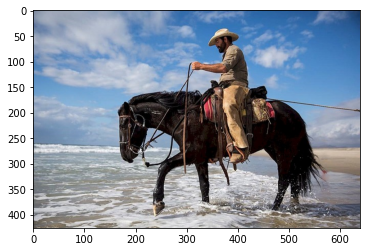

torch.Size([1, 21, 200, 5])
tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0195, 0.0121, 0.8325, 0.1498, 0.9729],
          [0.0115, 0.4305, 0.2309, 0.5102, 0.3969],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0670, 0.7310, 0.7857, 0.8504, 0.9431],
          [0.0482, 0.2568, 0.3209, 0.8609, 0.9024],
          [0.0235, 0.2334, 0.4086, 0.3535, 0.7434],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.00

In [9]:
from utils.ssd_model import DataTransform

# 1. 화상 읽기
image_file_path = "./data/cowboy-757575_640.jpg"
img = cv2.imread(image_file_path)  # [높이][폭][색BGR]
height, width, channels = img.shape  # 화상의 크기를 취득

# 2. 원본 화상 표시
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 3. 전처리 클래스 작성
color_mean = (104, 117, 123)  # (BGR)의 색의 평균값
input_size = 300  # 화상의 input 크기를 300×300으로 설정
transform = DataTransform(input_size, color_mean)

# 4. 전처리
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, "", "")  # 어노테이션은 없으므로, ""으로 설정
img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

# 5. SSD로 예측
net.eval()  # 네트워크를 추론 모드로
x = img.unsqueeze(0)  # 미니배치화: torch.Size([1, 3, 300, 300])
detections = net(x)

print(detections.shape)
print(detections)

# output : torch.Size([batch_num, 21, 200, 5])
#  = (batch_num, 클래스, conf의 top200, 규격화된 BBox의 정보)
#   규격화된 BBox의 정보(신뢰도, xmin, ymin, xmax, ymax)

출력 결과는 (1, 21, 200, 5) 텐서로 (batch_num 클래스, conf의 top200, 규격화된 BBox 정보)임. 규격화된 BBox 정보는 (신뢰도, xmin, ymin, xmax, ymax).

출력 결과의 텐서에서 신뢰도가 임계치 이상인 BBox만을 꺼내 이를 원본 화상 위에 그림.

ssd_predict_show.py 파일의 SSDPredictShow 클래스를 import하여 물체 감지 결과를 그리는 코드는 다음과 같음. 신뢰도 conf 0.6 이상인 BBox만 표시하도록 설정.

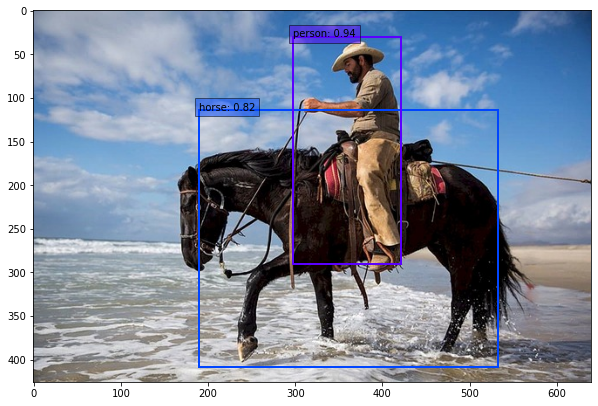

In [10]:
# 화상 예측
from utils.ssd_predict_show import SSDPredictShow

# 파일 경로
image_file_path = "./data/cowboy-757575_640.jpg"

# 에측 및 결과를 화상으로 그린다
ssd = SSDPredictShow(eval_categories=voc_classes, net=net)
ssd.show(image_file_path, data_confidence_level=0.6)

사람과 말을 감지한 모습을 확인할 수 있음. 50에폭만 학습하였기에 정확도는 떨어짐.

ssd300_mAP_77.43_v2.pth 모델을 로드하여 실행한 결과는 다음과 같음.

네트워크 설정 완료: 학습된 가중치를 로드했습니다


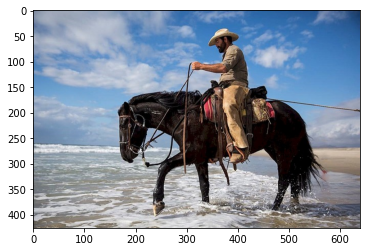

torch.Size([1, 21, 200, 5])
tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0217, 0.0143, 0.8602, 0.1342, 0.9310],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0385, 0.7289, 0.7485, 0.8518, 0.9207],
          [0.0211, 0.7424, 0.8170, 0.8265, 0.9280],
          [0.0146, 0.7626, 0.8616, 0.8466, 0.9242],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.00

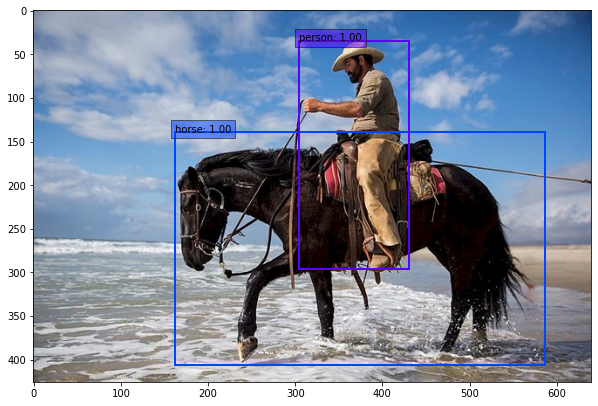

In [7]:
from utils.ssd_model import SSD

voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

# SSD300 설정
ssd_cfg = {
    'num_classes': 21,  # 배경 클래스를 포함한 총 클래스 수
    'input_size': 300,  # 화상의 입력 크기
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 출력할 DBox 화면비 종류
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 각 source의 화상 크기
    'steps': [8, 16, 32, 64, 100, 300],  # DBOX의 크기를 결정
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOX의 크기를 결정
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOX의 크기를 결정
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# SSD 네트워크 모델
net = SSD(phase="inference", cfg=ssd_cfg)

# SSD의 학습된 가중치를 설정
net_weights = torch.load('./weights/ssd300_mAP_77.43_v2.pth',
                         map_location={'cuda:0': 'cpu'})

# net_weights = torch.load('./weights/ssd300_mAP_77.43_v2.pth',
#                         map_location={'cuda:0': 'cpu'})

net.load_state_dict(net_weights)

print('네트워크 설정 완료: 학습된 가중치를 로드했습니다')

from utils.ssd_model import DataTransform

# 1. 화상 읽기
image_file_path = "./data/cowboy-757575_640.jpg"
img = cv2.imread(image_file_path)  # [높이][폭][색BGR]
height, width, channels = img.shape  # 화상의 크기를 취득

# 2. 원본 화상 표시
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 3. 전처리 클래스 작성
color_mean = (104, 117, 123)  # (BGR)의 색의 평균값
input_size = 300  # 화상의 input 크기를 300×300으로 설정
transform = DataTransform(input_size, color_mean)

# 4. 전처리
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, "", "")  # 어노테이션은 없으므로, ""으로 설정
img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

# 5. SSD로 예측
net.eval()  # 네트워크를 추론 모드로
x = img.unsqueeze(0)  # 미니배치화: torch.Size([1, 3, 300, 300])
detections = net(x)

print(detections.shape)
print(detections)

# output : torch.Size([batch_num, 21, 200, 5])
#  = (batch_num, 클래스, conf의 top200, 규격화된 BBox의 정보)
#   규격화된 BBox의 정보(신뢰도, xmin, ymin, xmax, ymax)

# 화상 예측
from utils.ssd_predict_show import SSDPredictShow

# 파일 경로
image_file_path = "./data/cowboy-757575_640.jpg"

# 에측 및 결과를 화상으로 그린다
ssd = SSDPredictShow(eval_categories=voc_classes, net=net)
ssd.show(image_file_path, data_confidence_level=0.6)